# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es preparar el entorno para realizar pruebas para Epilepsy a ser clasificado con las series con la ``Tendencia`` y ``Aceleración`` aplicadas sobre LSTM

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#cd0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'HeartBeat_tmp_test_data.pkl',
 'HeartBeat_tmp_train_data.pkl',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
EPILEPSY_PATH = "data/epilepsy"

DATA_TO_SAVE = "Epilepsy"

PKL_DIR = "pkl/LSTM/Epilepsy/"
PKL_NAME = "epilepsy_LSTM_trend_acc.pkl"

SEED = 1


# <font color=#cd0000> Carga del Dataset </font>

In [3]:
from utils.load_data import import_epilepsy_dataset

train, test = import_epilepsy_dataset(EPILEPSY_PATH)

In [4]:
train.reset_changes()
test.reset_changes()


# <font color=#cd0000> Preprocesamiento </font>

## <font color=#cd0000> Eliminación de datos inválidos y valores atípicos </font>
- Eliminaremos aquellos valores fuera de los percentiles 5 y 95.
- El grado de outliers mínimo en, al menos, una dimensión para eliminar una serie temporal será del 80% (si más del 80% de los datos son anómalos descartamos la serie).
  - A pesar de que esto pueda parecer muy grande debemos comprender que, la probabilidad con la que aparezca ruido en una de las dimensiones de una serie temporal multivariada, es muy alta (tenemos varias series temporales con ruido cada una).

In [5]:
train.remove_outliers(
    headers=train.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)

test.remove_outliers(
    headers=test.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)


In [6]:
import pandas as pd

# Remaining series
print("Train: Previous number of series: {}".format(
    len(pd.unique(train.original_data['id']))))
print("Train: Actual number of series: {}".format(
    len(pd.unique(train.derived_data['id']))))

print("Test: Previous number of series: {}".format(
    len(pd.unique(test.original_data['id']))))
print("Test: Actual number of series: {}".format(
    len(pd.unique(test.derived_data['id']))))


Train: Previous number of series: 137
Train: Actual number of series: 137
Test: Previous number of series: 138
Test: Actual number of series: 138


## <font color=#cd0000> Resoluciones a aplicar </font>
- Como concluimos en el análisis en profundidad, mantendremos la resolución original.

In [7]:
# Nothing to see here

# <font color=#cd0000> Codificación </font>
- Tendencia + Aceleración

In [8]:
from utils.codifications import temporal_trend_fn

train.apply_codifications([temporal_trend_fn])
test.apply_codifications([temporal_trend_fn])


In [9]:
columns = train.get_derived_data_columns()['attrs']
trend_columns = list(filter(lambda z: 'Diff' in z, columns))

train.apply_codifications([temporal_trend_fn], headers=trend_columns)
test.apply_codifications([temporal_trend_fn], headers=trend_columns)


## <font color=#cd0000> Normalización </font>

In [10]:
from utils.codifications import standardize_data

train.derived_data, test.derived_data = standardize_data(
    train.derived_data,
    test.derived_data,
    headers=train.get_derived_data_columns()['attrs']
)


## <font color=#cd0000> Tensores entrada y salida de la red </font>

In [11]:
# All lengths must be equal
series_length = train.get_shortest_serie().shape[0]
n_dims = len(train.get_derived_data_columns()['attrs'])

(
    train.get_shortest_serie().shape[0],
    train.get_largest_serie().shape[0],
    test.get_shortest_serie().shape[0],
    test.get_largest_serie().shape[0]
)


(204, 204, 204, 204)

In [12]:
import pandas as pd

# This will determine the number of series of each split
train_n_series = pd.unique(train.derived_data['id']).shape[0]
test_n_series = pd.unique(test.derived_data['id']).shape[0]

(train_n_series, test_n_series)


(137, 138)

In [13]:
X_train, _ = train.transform_derived_data_into_X_y()
X_test, _ = test.transform_derived_data_into_X_y()

y_train = train.derived_data.groupby('id').first()['class'].to_numpy()
y_test = test.derived_data.groupby('id').first()['class'].to_numpy()


## <font color=#cd0000> Técnicas de balanceo </font>

### <font color=#cd0000> Asignación de pesos a las clases </font>

In [14]:
import numpy as np
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1],
                 2: class_weights[2], 3: class_weights[3]}


In [15]:
from utils.classifier_utils import apply_lstm_format
from sklearn.preprocessing import OneHotEncoder

sequences_fragmenter = 1

enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))

X_train, y_train = apply_lstm_format(
    X_train, y_train.reshape(-1, 1), train_n_series, series_length, sequences_fragmenter, enc)
X_test, y_test = apply_lstm_format(
    X_test, y_test.reshape(-1, 1), test_n_series, series_length, sequences_fragmenter, enc)


# <font color=#cd0000> Diseño de la topología de red </font>

## <font color=#cd0000> Preparación de mecanismo argmax en caso de salida multiclase </font>

In [16]:
import numpy as np
import keras.backend as K


def argmax(x, n_classes):
    all_predictions = []
    for max_class_position in K.argmax(x):
        prediction = np.zeros(n_classes)
        prediction.put(max_class_position, 1)
        all_predictions.append(prediction)
    return np.asarray(all_predictions)


In [17]:
import keras as k
from keras.models import Sequential
from keras.layers import LSTM, Dense

nn = Sequential()

# Number of initial dimensions
nn.add(LSTM(units=12, return_sequences=True, dropout=.2, recurrent_dropout=.2))
nn.add(LSTM(units=6, dropout=.2, recurrent_dropout=.2))
# Number of Epilepsy's classes
nn.add(Dense(4, activation='softmax'))


## <font color=#cd0000> Compilación de la red </font>

In [18]:
from keras.optimizers import RMSprop

metrics = [
    k.metrics.CategoricalAccuracy(name="ACC"),
    k.metrics.Precision(name='Prec'),
    k.metrics.Recall(name='Rec'),
    k.metrics.AUC(name='AUC')
]

nn.compile(optimizer=RMSprop(
    learning_rate=5e-3), loss='categorical_crossentropy', metrics=metrics)


## <font color=#cd0000> Visualización de resultados preliminares </font>

In [19]:
import matplotlib.pyplot as plt


def show_metrics(history):
    for metric in history.history.keys():
        if not metric.startswith('val_'):
            plt.plot(history.history[metric], label=metric)
            plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
            plt.title(metric)
            plt.ylabel('')
            plt.xlabel('Epoch')
            plt.legend(loc="upper left")
            plt.show()


## <font color=#cd0000> Entrenamiento del modelo </font>

Epoch 1/25
5/5 [==============================] - 2s 407ms/step - loss: 0.0503 - ACC: 0.9927 - Prec: 0.9927 - Rec: 0.9927 - AUC: 0.9952 - val_loss: 0.2164 - val_ACC: 0.9493 - val_Prec: 0.9493 - val_Rec: 0.9493 - val_AUC: 0.9860
Epoch 2/25
5/5 [==============================] - 1s 262ms/step - loss: 0.0302 - ACC: 0.9854 - Prec: 0.9854 - Rec: 0.9854 - AUC: 0.9999 - val_loss: 0.1794 - val_ACC: 0.9638 - val_Prec: 0.9638 - val_Rec: 0.9638 - val_AUC: 0.9867
Epoch 3/25
5/5 [==============================] - 2s 397ms/step - loss: 0.0484 - ACC: 0.9854 - Prec: 0.9854 - Rec: 0.9854 - AUC: 0.9990 - val_loss: 0.2526 - val_ACC: 0.9493 - val_Prec: 0.9493 - val_Rec: 0.9493 - val_AUC: 0.9778
Epoch 4/25
5/5 [==============================] - 2s 340ms/step - loss: 0.0406 - ACC: 0.9927 - Prec: 0.9927 - Rec: 0.9927 - AUC: 0.9996 - val_loss: 0.2810 - val_ACC: 0.9420 - val_Prec: 0.9420 - val_Rec: 0.9420 - val_AUC: 0.9775
Epoch 5/25
5/5 [==============================] - 2s 433ms/step - loss: 0.0118 - ACC: 1.

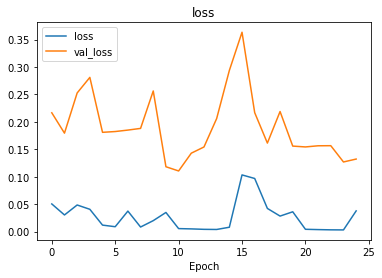

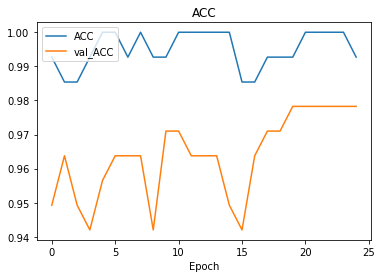

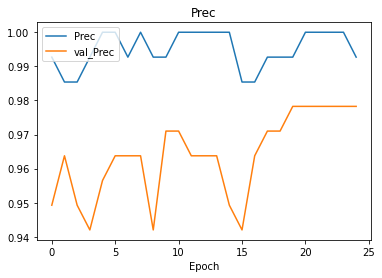

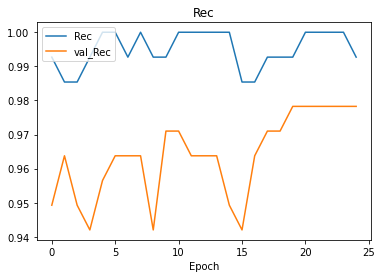

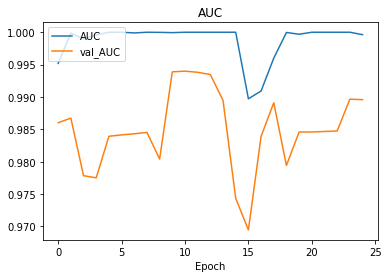

In [38]:
import numpy as np
from keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

epochs = 25

history = nn.fit(X_train, y_train, epochs=epochs,
                 validation_data=(X_test, y_test),
                 class_weight=class_weights,
                 verbose=1)
nn.summary()
print('\n\n')

y_pred = argmax(nn.predict(X_test), 4)

show_metrics(history)

## <font color=#cd0000> Clasificación </font>

In [39]:
y_real = enc.inverse_transform(y_test)
y_pred = enc.inverse_transform(y_pred)
print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, zero_division=0))

[[31  1  0  2]
 [ 0 37  0  0]
 [ 0  0 30  0]
 [ 0  0  0 37]]
              precision    recall  f1-score   support

    epilepsy       1.00      0.91      0.95        34
     running       0.97      1.00      0.99        37
      sawing       1.00      1.00      1.00        30
     walking       0.95      1.00      0.97        37

    accuracy                           0.98       138
   macro avg       0.98      0.98      0.98       138
weighted avg       0.98      0.98      0.98       138



## <font color=#cd0000> Discusión de los resultados </font>
- Dimensionalidad de entrada inicial -> 3 atributos
- Vamos a estudiar diferentes rangos de hiper-parámetros que podrían darnos alguna pista sobre el rango en el que buscar el mejor clasificador de este tipo:
  - Para una red profunda de 2 capas dada la complejidad de las series (son rápidas):
   - Para un `n_units_capa1` de 2 veces la dim_entrada (6), `n_units_capa2` de 3 y un `learning_rate` rápido (1e-2) observamos resultados bastantes  mejores en comparación con aplicar la clasificación sobre las series en bruto y tampoco observamos un sobreajuste importante aunque sí existe y, por ello, aplicaremos una tasa de 0.2 de Dropout:
   ```
   Confusion matrix:
   [[31  1  2  0]
    [ 1 35  1  0]
    [ 1  0 29  0]
    [ 3  0  3 31]]

   Classification report:
                  precision    recall  f1-score   support

      epilepsy       0.86      0.91      0.89        34
       running       0.97      0.95      0.96        37
        sawing       0.83      0.97      0.89        30
       walking       1.00      0.84      0.91        37

      accuracy                           0.91       138
     macro avg       0.92      0.92      0.91       138
  weighted avg       0.92      0.91      0.91       138
   ```
   - Para un `n_units_capa1` de 2 veces la dim_entrada (6), `n_units_capa2` de 3 y un `learning_rate` rápido (1e-2) con una tasa de Dropout de 0.2 a ambas capas ocultas y observamos que los resultados empeoran y no logramos librarnos del sobreajuste al llevgar a la convergencia por lo que eliminaremos dicha tasa de Dropout y, además, disminuiremos las épocas de aprendizaje a 50 porque el modelo ya converge para entonces. También probaremos a incrementar la complejidad del modelo incrementando el número de neuronas al doble:
   ```
   Confusion matrix:
   [[24  8  0  2]
    [ 0 35  2
    [ 0  4 26  0]
    [ 5  1  0 31]]

   Classification report:
                 precision    recall  f1-score   support

      epilepsy       0.83      0.71      0.76        34
       running       0.73      0.95      0.82        37
        sawing       0.93      0.87      0.90        30
       walking       0.94      0.84      0.89        37

      accuracy                           0.84       138
     macro avg       0.86      0.84      0.84       138
  weighted avg       0.85      0.84      0.84       138
   ```
   - Para un `n_units_capa1` de 4 veces la dim_entrada (12), `n_units_capa2` de 6 y un `learning_rate` rápido (1e-2) observamos unos resultados mejores como resultado de aplicar una mayor complejidad, probemos ahora a disminuir la tasa de aprendizaje a la mitad:
   ```
   Confusion matrix:
   [[33  1  0  0]
    [ 2 35  0  0]
    [ 0  0 30  0]
    [ 4  3  0 30]]

   Classification report:
                  precision    recall  f1-score   support

       epilepsy       0.85      0.97      0.90        34
        running       0.90      0.95      0.92        37
         sawing       1.00      1.00      1.00        30
        walking       1.00      0.81      0.90        37

       accuracy                           0.93       138
      macro avg       0.94      0.93      0.93       138
   weighted avg       0.93      0.93      0.93       138
   ```
   - Para un `n_units_capa1` de 2 veces la dim_entrada (6), `n_units_capa2` de 3 y un `learning_rate` rápido (5e-3) obtenemos mejores resultados y en menos tiempo lo cual indica que si disminuimos el número de eépocas a la mitad obtendremos resultados similares en menos teimpo:
   ```
   Confusion matrix:
   [[31  1  0  2
    [ 2 35  0  0]
    [ 0  0 30  0]
    [ 2  0  0 35]]

   Classification report:
                  precision    recall  f1-score   support

       epilepsy       0.89      0.91      0.90        34
        running       0.97      0.95      0.96        37
         sawing       1.00      1.00      1.00        30
        walking       0.95      0.95      0.95        37

       accuracy                           0.95       138
      macro avg       0.95      0.95      0.95       138
   weighted avg       0.95      0.95      0.95       138
   ```
   - Para un `n_units_capa1` de 2 veces la dim_entrada (6), `n_units_capa2` de 3 y un `learning_rate` rápido (5e-3) y disminuimos las e´pocas a 25 y obtenemos resultados mejores y en menos tiempo:
   ```
   Confusion matrix:
   [[31  1  0  2]
    [ 0 37  0  0]
    [ 0  0 30  0]
    [ 0  0  0 37]]

   Classification report:
                  precision    recall  f1-score   support

       epilepsy       1.00      0.91      0.95        34
        running       0.97      1.00      0.99        37
         sawing       1.00      1.00      1.00        30
        walking       0.95      1.00      0.97        37

       accuracy                           0.98       138
      macro avg       0.98      0.98      0.98       138
   weighted avg       0.98      0.98      0.98       138
   ```

## <font color=#cd0000> Conclusiones </font>
- Como podemos observar la influencia de las codificaciones aplicadas es significativa y va a ser difícil encontrar un resultado mejor al ya obtenido (quizás aumentando el número de unidades).
- Unos rangos orientativos de búsqueda podrían ser:
  - `n_units_capa_1`: [12, 24]
  - `n_units_capa_2` fijo a 6
  - `learning_rate`: [1e-2, 8e-3, 7e-3, 5e-3, 1e-3]

# <font color=#cd0000> Randomized Search </font>
- Búsqueda de hiper-parámetros aleatoria con LSTM maximizando ``macro avg f1-score``

## <font color=#cd0000> Rangos de búsqueda </font>
- Como vimos anteriormente los rangos de búsqueda aleatoria de los mejores hiper-parámetros serán los siguientes

In [20]:
N_UNITS_RANGE = range(12, 24)
LEARNING_RATE_CHOICES = [1e-2, 8e-3, 7e-3, 5e-3, 1e-3]

In [21]:
import random
import pickle
import utils.constants as cs
from utils.classifier_utils import (windowed_cross_val,
                                    compute_classification_reports_means)
from utils.plot_utils import pretty_print_classification_report_dict
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop


def lstm_randomized_search_cv(
        windowed_series,
        relation_with_series,
        prefix,
        cv=5,
        lstm_dict={}):
    global PKL_DIR
    all_clf_used = {}

    n_samples = 5
    units_list = random.sample(
        list(N_UNITS_RANGE), n_samples)
    learning_rate_list = random.sample(
        LEARNING_RATE_CHOICES, n_samples)

    best_hyp_params = None
    best_score = 0
    for units in units_list:
        for learning_rate in learning_rate_list:
            lstm_dict[cs.LSTM_HYP_PARAM_UNITS] = units
            lstm_dict[cs.LSTM_HYP_PARAM_LEARNING_RATE] = learning_rate
            reports = windowed_cross_val(
                None,
                windowed_series,
                relation_with_series,
                cv=cv,
                seed=SEED,
                drop_columns=['class'],
                estimator_type=cs.ESTIMATOR_LSTM,
                lstm_dict=lstm_dict
            )

            mean_report = compute_classification_reports_means(reports)
            all_clf_used[(units, learning_rate)] = mean_report

            if mean_report['macro avg']['f1-score'][0] >= best_score:
                best_score = mean_report['macro avg']['f1-score'][0]
                best_hyp_params = (units, learning_rate)
                best_report = mean_report

            print("\t\t--------------ACTUAL BEST: Units={}; Learning Rate={}--------------"
                  .format(best_hyp_params[0], best_hyp_params[1]))
            pretty_print_classification_report_dict(best_report)
            print("\t\t--------------ITERATION: Units={}; Learning Rate={}--------------"
                  .format(units, learning_rate))
            pretty_print_classification_report_dict(mean_report)

    with open(PKL_DIR + prefix, 'wb') as file:
        pickle.dump(all_clf_used, file)

    return best_hyp_params, best_report


In [22]:
# IMPORTANTE -> ALGUNOS DE LOS PARÁMETROS DEL MODELO SON FIJADOS EN EL MÉTODO lstm_build_model del módulo
# classifier_utils.py ante problemas a la hora de clonar modelos neuronales de Keras.

# Los parámetros fijados a fuego en el código son:
#   · Una segunda capa oculta con el nº de neuronas fijas a 6

lstm_dict = {
    cs.LSTM_SERIES_LENGTH: series_length,
    cs.LSTM_SEQUENCES_FRAGMENTER: 1,
    cs.LSTM_FITTED_LABELS_ENCODER: enc,
    cs.LSTM_ARGMAX_FUNCTION: argmax,
    cs.LSTM_N_CLASSES: 4,
    cs.LSTM_CLASS_WEIGHTS: class_weights,
    cs.LSTM_HYP_PARAM_EPOCHS: 25
}

lstm_randomized_search_cv(
    train.derived_data,
    train.derived_data_windows_per_serie,
    PKL_NAME,
    cv=5,
    lstm_dict=lstm_dict
)


		--------------ACTUAL BEST: Units=14; Learning Rate=0.008--------------
Accuracy: 0.8692209450830142 +/- 0.04780391937713548
epilepsy:
	precision: 0.96 +/- 0.07999999999999999
	recall: 0.9777777777777779 +/- 0.04444444444444447
	f1-score: 0.966013071895425 +/- 0.04478912862486747
	support: 6.8 +/- 1.6
running:
	precision: 0.8883116883116884 +/- 0.13685132334877392
	recall: 0.6914285714285715 +/- 0.21706060472238847
	f1-score: 0.7454606796712059 +/- 0.13199944020909654
	support: 7.2 +/- 1.16619037896906
sawing:
	precision: 0.85 +/- 0.1855921454276674
	recall: 0.9199999999999999 +/- 0.16
	f1-score: 0.8573684210526314 +/- 0.11834968609779237
	support: 6.0 +/- 0.6324555320336759
walking:
	precision: 0.9036363636363636 +/- 0.08558983487956232
	recall: 0.8899999999999999 +/- 0.10198039027185568
	f1-score: 0.8914285714285715 +/- 0.06552768537816976
	support: 7.4 +/- 2.0591260281974
macro avg:
	precision: 0.900487012987013 +/- 0.03727150799198333
	recall: 0.8698015873015873 +/- 0.043269283367

((23, 0.005),
 {'accuracy': (0.9407407407407409, 0.05023948135648345),
  'epilepsy': {'precision': (0.975, 0.049999999999999996),
   'recall': (0.9777777777777779, 0.04444444444444447),
   'f1-score': (0.9749019607843138, 0.03083859333543137),
   'support': (6.8, 1.6)},
  'running': {'precision': (0.9083333333333332, 0.1301708279317776),
   'recall': (0.96, 0.07999999999999999),
   'f1-score': (0.9244444444444445, 0.07516237566794559),
   'support': (7.2, 1.16619037896906)},
  'sawing': {'precision': (1.0, 0.0),
   'recall': (0.8857142857142858, 0.22857142857142856),
   'f1-score': (0.9199999999999999, 0.16),
   'support': (6.0, 0.6324555320336759)},
  'walking': {'precision': (0.9444444444444444, 0.07027283689263066),
   'recall': (0.9577777777777777, 0.05183068350973601),
   'f1-score': (0.9490696438064858, 0.04563051394574692),
   'support': (7.4, 2.0591260281974)},
  'macro avg': {'precision': (0.9569444444444445, 0.027829812374324844),
   'recall': (0.9453174603174602, 0.050800098

# <font color=#cd0000> Randomized Search con múltiples ejecuciones en lugar de Validación Cruzada </font>
- En este caso ejecutaremos CV dado que tenemos suficientes series

In [ ]:
# Nothing to see here

# <font color=#cd0000> Análisis de resultados </font>
- Según la búsqueda aleatoria de hiper-parámetros, la mejor combinación, es la de ``n_units`` = 23 y ``learning_rate`` = 0.005:
    ```
        Accuracy: 0.9407407407407409 +/- 0.05023948135648345
        epilepsy:
            precision: 0.975 +/- 0.049999999999999996
            recall: 0.9777777777777779 +/- 0.04444444444444447
            f1-score: 0.9749019607843138 +/- 0.03083859333543137
            support: 6.8 +/- 1.6
        running:
            precision: 0.9083333333333332 +/- 0.1301708279317776
            recall: 0.96 +/- 0.07999999999999999
            f1-score: 0.9244444444444445 +/- 0.07516237566794559
            support: 7.2 +/- 1.16619037896906
        sawing:
            precision: 1.0 +/- 0.0
            recall: 0.8857142857142858 +/- 0.22857142857142856
            f1-score: 0.9199999999999999 +/- 0.16
            support: 6.0 +/- 0.6324555320336759
        walking:
            precision: 0.9444444444444444 +/- 0.07027283689263066
            recall: 0.9577777777777777 +/- 0.05183068350973601
            f1-score: 0.9490696438064858 +/- 0.04563051394574692
            support: 7.4 +/- 2.0591260281974
        macro avg:
            precision: 0.9569444444444445 +/- 0.027829812374324844
            recall: 0.9453174603174602 +/- 0.05080009879707811
            f1-score: 0.942104012258811 +/- 0.0514724546961723
            support: 27.4 +/- 0.8
        weighted avg:
            precision: 0.9537037037037038 +/- 0.03424396277353126
            recall: 0.9407407407407409 +/- 0.05023948135648345
            f1-score: 0.9377839859436007 +/- 0.05566503919925217
            support: 27.4 +/- 0.8
    ```
- Ahora vamos a visualizar la evolución de los resultados (25 resultados) para observar cómo avanza nuestra métrica objetivo -> Macro Average F1-Score.

In [23]:
import pickle

all_reports = pickle.load(open(PKL_DIR + PKL_NAME, 'rb'))


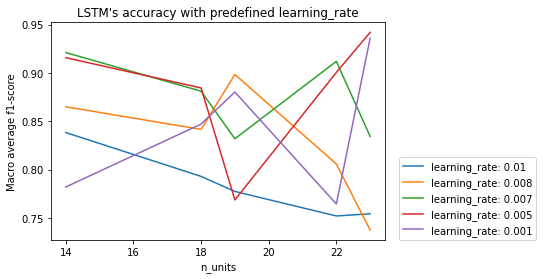

In [24]:
from utils.plot_utils import plot_score

macro_avg_f1_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['macro avg']['f1-score'][0],
                   'std': all_reports[z]['macro avg']['f1-score'][1]}),
    all_reports
))

plot_score(
    [macro_avg_f1_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Macro Average F1-Score'
)


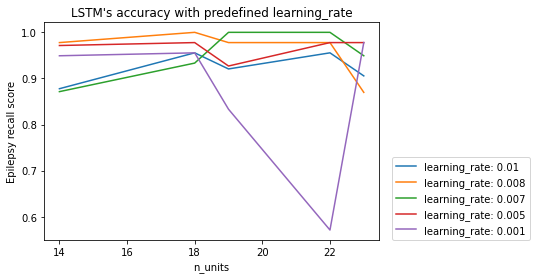

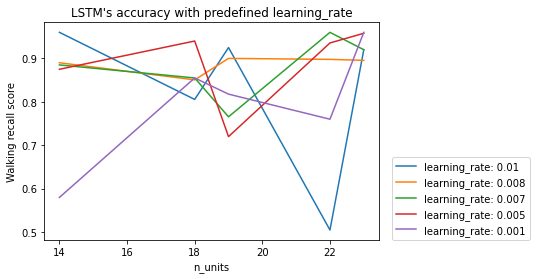

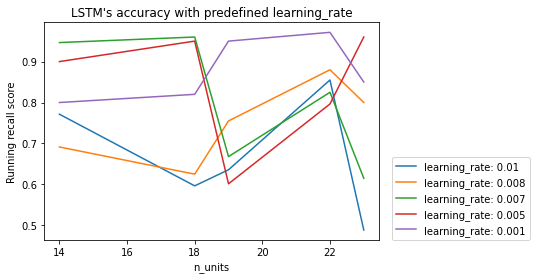

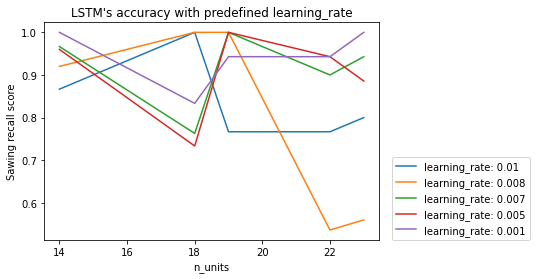

In [25]:
epilepsy_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['epilepsy']['recall'][0],
                   'std': all_reports[z]['epilepsy']['recall'][1]}),
    all_reports
))

walking_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['walking']['recall'][0],
                   'std': all_reports[z]['walking']['recall'][1]}),
    all_reports
))

running_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['running']['recall'][0],
                   'std': all_reports[z]['running']['recall'][1]}),
    all_reports
))

sawing_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['sawing']['recall'][0],
                   'std': all_reports[z]['sawing']['recall'][1]}),
    all_reports
))

plot_score(
    [epilepsy_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Epilepsy recall score'
)

plot_score(
    [walking_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Walking recall score'
)

plot_score(
    [running_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Running recall score'
)

plot_score(
    [sawing_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Sawing recall score'
)


## <font color=#cd0000> Evaluación sobre el conjunto de validación </font>
- Vamos a llevar a cabo la evaluación final sobre el conjunto de validación (esto es lo que irá al apartado de ``Pruebas y Resultados`` de la memoria).

### <font color=#cd0000> Construcción del modelo </font>

In [26]:
import keras as k
from keras.models import Sequential
from keras.layers import LSTM, Dense

nn = Sequential()

# Number of initial dimensions
nn.add(LSTM(units=23, dropout=.2, recurrent_dropout=.2, return_sequences=True))
nn.add(LSTM(units=6, dropout=.2, recurrent_dropout=.2))
# Number of Epilepsy's classes
nn.add(Dense(4, activation='softmax'))


In [27]:
from keras.optimizers import RMSprop

metrics = [
    k.metrics.CategoricalAccuracy(name="ACC"),
    k.metrics.Precision(name='Prec'),
    k.metrics.Recall(name='Rec'),
    k.metrics.AUC(name='AUC')
]

nn.compile(optimizer=RMSprop(
    learning_rate=0.005), loss='categorical_crossentropy', metrics=metrics)


### <font color=#cd0000> Entrenamiento </font>

Epoch 1/25
5/5 [==============================] - 2s 301ms/step - loss: 1.3441 - ACC: 0.3358 - Prec: 0.0000e+00 - Rec: 0.0000e+00 - AUC: 0.6170 - val_loss: 1.2454 - val_ACC: 0.5725 - val_Prec: 0.0000e+00 - val_Rec: 0.0000e+00 - val_AUC: 0.7839
Epoch 2/25
5/5 [==============================] - 1s 120ms/step - loss: 1.1948 - ACC: 0.5620 - Prec: 1.0000 - Rec: 0.0511 - AUC: 0.7796 - val_loss: 1.0007 - val_ACC: 0.6014 - val_Prec: 1.0000 - val_Rec: 0.2899 - val_AUC: 0.8897
Epoch 3/25
5/5 [==============================] - 1s 122ms/step - loss: 0.9612 - ACC: 0.6423 - Prec: 0.9216 - Rec: 0.3431 - AUC: 0.8910 - val_loss: 1.2416 - val_ACC: 0.5652 - val_Prec: 0.7143 - val_Rec: 0.2174 - val_AUC: 0.7160
Epoch 4/25
5/5 [==============================] - 1s 118ms/step - loss: 0.9274 - ACC: 0.7445 - Prec: 0.9200 - Rec: 0.3358 - AUC: 0.8825 - val_loss: 0.8804 - val_ACC: 0.7899 - val_Prec: 0.8667 - val_Rec: 0.4710 - val_AUC: 0.9090
Epoch 5/25
5/5 [==============================] - 1s 124ms/step - loss: 

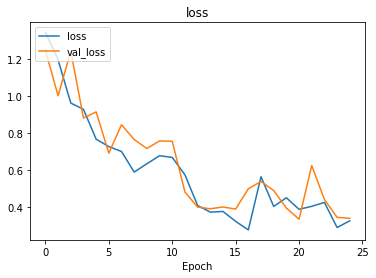

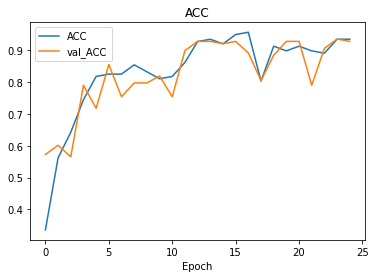

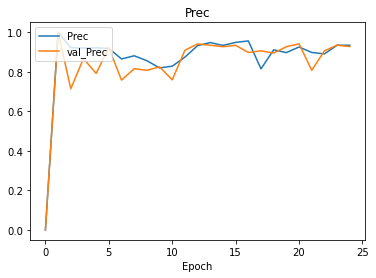

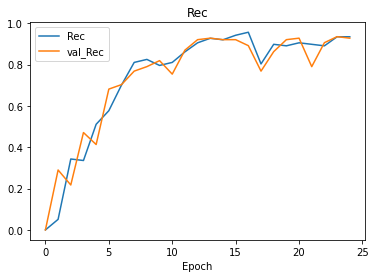

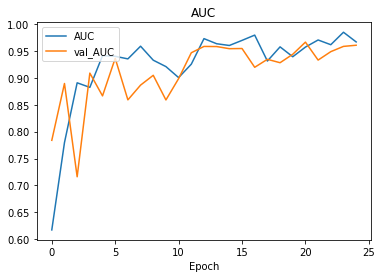

In [28]:
import numpy as np
from keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

epochs = 25

history = nn.fit(X_train, y_train, epochs=epochs,
                 validation_data=(X_test, y_test))
nn.summary()
print('\n\n')

y_pred = argmax(nn.predict(X_test), 4)

show_metrics(history)

### <font color=#cd0000> Clasificación </font>

In [29]:
y_real = enc.inverse_transform(y_test)
y_pred = enc.inverse_transform(y_pred)
print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, zero_division=0))

[[26  3  1  4]
 [ 0 37  0  0]
 [ 0  2 28  0]
 [ 0  0  0 37]]
              precision    recall  f1-score   support

    epilepsy       1.00      0.76      0.87        34
     running       0.88      1.00      0.94        37
      sawing       0.97      0.93      0.95        30
     walking       0.90      1.00      0.95        37

    accuracy                           0.93       138
   macro avg       0.94      0.92      0.93       138
weighted avg       0.93      0.93      0.93       138



# <font color=#cd0000> Conclusiones </font>
- Con respecto a los resultados obtenemos unos claramente mejores a los obtenidos al evaluar LSTM sobre las series en bruto y esto se debe a que tenemos en cuenta la tendencia de las series y el orden secuencial de la información.